In [1]:
# Setup
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

# Set mpl defaults
mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [2]:
# Import the weather timeseries dataset
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True,
    cache_dir='./data')

csv_path, _ = os.path.splitext(zip_path)
csv_path

13574144/13568290 [==============================] - 2s 0us/step


'./data/datasets/jena_climate_2009_2016.csv'

In [4]:
df = pd.read_csv(csv_path)
# Data is in minute format, we should take hours
df = df[5::6] # Starting from row 5, take every 6th row
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


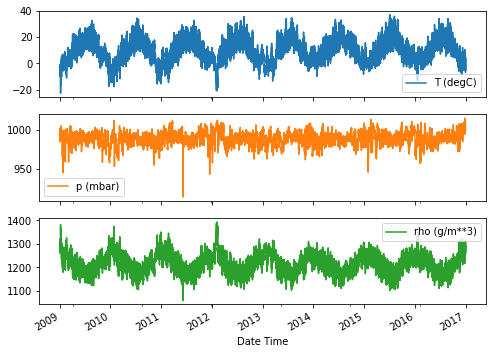

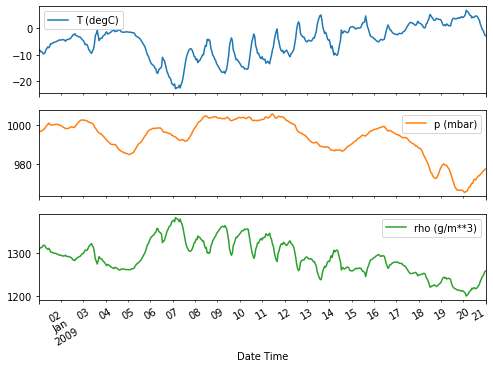

In [5]:
# PLot some feature evolution
cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plt_ft = df[cols]
plt_ft.index = date_time
_ = plt_ft.plot(subplots=True)

plt_ft = plt_ft[:480]
_ = plt_ft.plot(subplots=True)

In [8]:
# Inspect and clean
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


In [9]:
# Wind velocity has a minimum of -9999 which looks dodgy, especially given that we have a wind direction
# so the "velocity" is actually probably a speed and should be >0
# Replace the -9999 values with 0's using masking
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

df['wv (m/s)'].min()

0.0

## Feature Engineering
It's important to understand the data and ensure we are using appropriately formatted data.

Wind: The wind direction is degrees is not a good model input because 360/0 should be close to each other and wrap around smoothly. It shouldn't matter if the wind is not blowing.

Text(0, 0.5, 'Speed (m/s)')

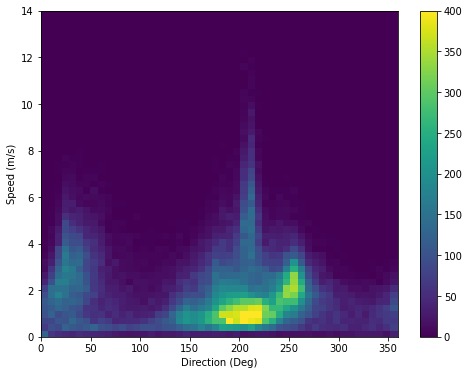

In [10]:
# Plot direction dist
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50,50), vmax=400)
plt.colorbar()
plt.xlabel('Direction (Deg)')
plt.ylabel('Speed (m/s)')

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

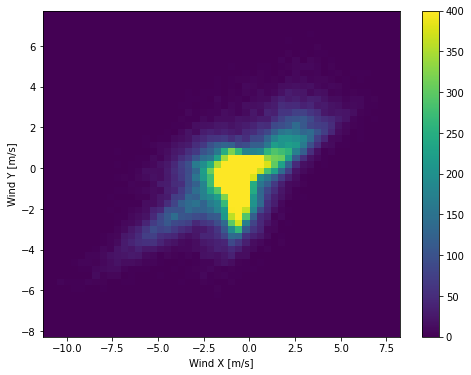

In [11]:
# This looks confusing because of the spread around 360 degrees. We should convert the direction/speed into a vector
# which will be easier to interpret
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians
wd_rad = (df.pop('wd (deg)') * np.pi) / 180

# Get wind x and y components
df['wx'] = wv*np.cos(wd_rad)
df['wy'] = wv*np.sin(wd_rad)
df['max_wx'] = max_wv*np.cos(wd_rad)
df['max_wy'] = max_wv*np.sin(wd_rad)

plt.hist2d(df['wx'], df['wy'], bins=(50,50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

We can now see that the wind speed is centred around 0 for the majority of time.

### Time
Time is also useful but shouldn't be used in string format

Text(0, 0.5, 'Time of Day Signal')

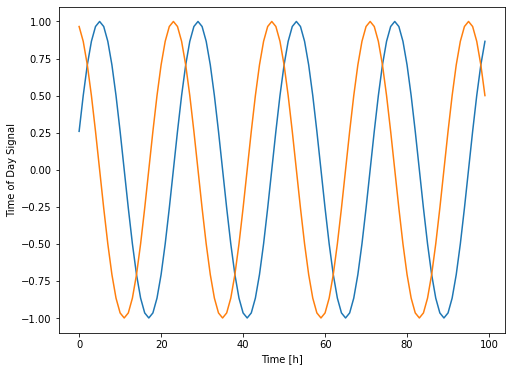

In [14]:
timestamp_s = date_time.map(datetime.datetime.timestamp) # convert to seconds

# Time in seconds is also not a useful model input as its just continuous linear increase.
# We could convert it into SIN/COS curves that represent the periodicity we are interested in
# for us this is day/year
day = 24*60*60 # <== day in seconds
year = (365.2524) * day # <== Year in seconds

df['day_sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['day_cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['year_sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['year_cos'] = np.cos(timestamp_s * (2 * np.pi / year))

plt.plot(np.array(df.day_sin)[:100])
plt.plot(np.array(df.day_cos)[:100])
plt.xlabel('Time [h]')
plt.ylabel('Time of Day Signal')

This gives the model access to the frequency features of the data, in this case we knew what frequencies were important. 

If we don't know we can use a fats fourier transform to extract the distribution of frequencies and choose the most important from the peaks of this distribution.

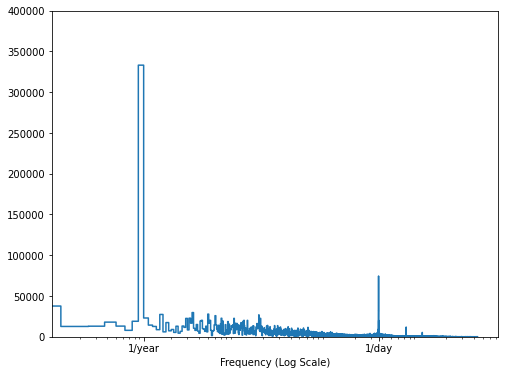

In [16]:
# fft of temperature over time
fft = tf.signal.rfft(df['T (degC)'])
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(df['T (degC)'])
hours_per_year = 24 * 365.2524
years_per_dataset = n_sample_h / (hours_per_year)

f_per_year = f_per_dataset / years_per_dataset
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 365.2524], labels=['1/year', '1/day'])
_ = plt.xlabel('Frequency (Log Scale)')

# We can clearly see large peaks at a feequency of 1 year and 1 day, indictaing that these are
# the important periodicities

## Splitting the Data

Apply a 70/20/10 split for train/val/test

The data wont be randomly shuffled so that we can chop the data into windows of consecutive samples

And it means the test data occurs after the train/val which is realistic for time series data

In [45]:
col_idx = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0 : int(n * 0.7)].reset_index(drop=True)
val_df = df[int(n*0.7):int(n*0.9)].reset_index(drop=True)
test_df = df[int(n*0.9):].reset_index(drop=True)

num_features = df.shape[1]
num_features

19

In [46]:
# Normalise the data, (feature - feature.mean() / feature.std())
# The validation/test sets shoul dbe normalised using the mean/std of the training set so the model is unaware of
# values in val/test

# Ideally We should use a sliding mean/std becaus the model shouldn't be aware of the future during training.
# This can be done by doing a Smoothed Moving Average, e.g instead of subsetting the data we should use a grouper
# and group per hour and nromalise within each hour?

# https://medium.com/@kkmphele/time-series-prediction-using-recurrent-neural-network-with-tensorflow-js-f8bef4df7780
# This says that we should use the SMA as the lable for the training vector which is a period group?

# For simplicity we will just use a single mean/std
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std
test_df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wx,wy,max_wx,max_wy,day_sin,day_cos,year_sin,year_cos
0,1.599724,-0.728855,-0.846438,-0.480418,0.821124,-0.764821,-0.633744,-0.667960,-0.656453,-0.654069,1.089310,1.623820,1.106908,1.557556,1.016688,-1.224695,0.707177,1.258575,0.521178
1,1.653958,-0.734632,-0.856754,-0.563604,0.615753,-0.767420,-0.700280,-0.613992,-0.720093,-0.719796,1.112016,1.704558,0.855454,1.888362,0.898892,-0.999944,1.000056,1.258938,0.520236
2,1.684087,-0.768139,-0.892285,-0.593724,0.645954,-0.788214,-0.721666,-0.626446,-0.742555,-0.743270,1.153523,1.660785,1.082109,1.443980,0.911444,-0.707042,1.224790,1.259300,0.519293
3,1.666010,-0.829376,-0.950739,-0.542091,0.990254,-0.822003,-0.683646,-0.717775,-0.705119,-0.703364,1.205528,1.043796,1.479713,1.060063,1.414679,-0.365951,1.366064,1.259661,0.518351
4,1.658778,-0.836308,-0.957616,-0.550696,0.990254,-0.827201,-0.690775,-0.717775,-0.712606,-0.710407,1.211876,1.804237,1.284633,1.767462,1.197013,0.000085,1.414249,1.260022,0.517408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7005,1.629854,-1.165600,-1.281981,-1.428459,-0.235937,-0.996148,-1.251577,-0.499831,-1.262910,-1.264390,1.555401,-0.129648,0.148238,-0.119794,0.175300,-1.348713,0.425346,-0.077472,1.427959
7006,1.535849,-1.214127,-1.322097,-1.640728,-0.580840,-1.019541,-1.356133,-0.443788,-1.363986,-1.365328,1.583967,-0.060615,-0.214379,-0.123420,-0.251059,-1.192685,0.759924,-0.076449,1.427959
7007,1.510540,-1.370107,-1.475683,-1.649333,-0.181573,-1.087119,-1.358509,-0.549647,-1.367729,-1.370023,1.734122,-0.033443,0.415894,-0.157093,0.487113,-0.955371,1.042721,-0.075426,1.427959
7008,1.445460,-1.386283,-1.487144,-1.685190,-0.217815,-1.094917,-1.375143,-0.545496,-1.382704,-1.384107,1.734366,0.155773,0.116774,0.133325,0.115670,-0.652945,1.254466,-0.074403,1.427959


In [47]:
train_df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wx,wy,max_wx,max_wy,day_sin,day_cos,year_sin,year_cos
0,0.945308,-1.982473,-2.041888,-1.918973,1.117102,-1.302851,-1.477323,-0.790424,-1.480036,-1.482697,2.218524,0.193409,0.221161,0.111140,0.217928,0.366121,1.366064,-0.071033,1.427951
1,0.959770,-2.078372,-2.138166,-2.060964,1.044617,-1.330143,-1.534354,-0.786272,-1.536190,-1.539035,2.325708,0.172987,0.222101,0.109458,0.227798,0.707212,1.224790,-0.070009,1.427947
2,0.986284,-2.070284,-2.132435,-2.045187,1.062738,-1.328843,-1.527225,-0.788348,-1.528703,-1.531992,2.323998,0.207983,0.276266,0.111218,0.324078,1.000113,1.000056,-0.068986,1.427943
3,1.004362,-2.098014,-2.161090,-2.096820,1.008375,-1.336641,-1.546235,-0.782121,-1.547420,-1.553119,2.358913,0.270343,0.195267,0.246907,0.145176,1.224864,0.707177,-0.067963,1.427938
4,1.061006,-2.165028,-2.232152,-2.187178,0.984214,-1.353535,-1.579503,-0.782121,-1.581113,-1.585982,2.446320,0.112264,0.350818,0.048640,0.402053,1.366149,0.366112,-0.066940,1.427932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49058,0.169167,0.904892,0.886564,1.571997,0.947972,0.776492,1.984916,-0.493604,1.979016,1.977352,-0.882480,-0.166720,-1.508412,-0.155728,-1.363530,-1.192685,0.759924,-0.845608,-1.161419
49059,0.266787,0.879473,0.853325,1.405624,0.621793,0.742703,1.680752,-0.283962,1.672043,1.672192,-0.822662,-0.824901,-0.641039,-0.704391,-0.475387,-0.955371,1.042721,-0.846469,-1.160875
49060,0.217374,0.740824,0.719224,1.425703,1.086900,0.559461,1.716396,-0.605690,1.709479,1.707403,-0.716211,-0.030746,0.645277,0.013960,0.600050,-0.652945,1.254466,-0.847330,-1.160331
49061,0.213759,0.710783,0.689423,1.412795,1.147303,0.521772,1.692633,-0.645127,1.687018,1.683929,-0.689842,0.014300,-0.102616,-0.095117,-0.198426,-0.306016,1.380728,-0.848191,-1.159786


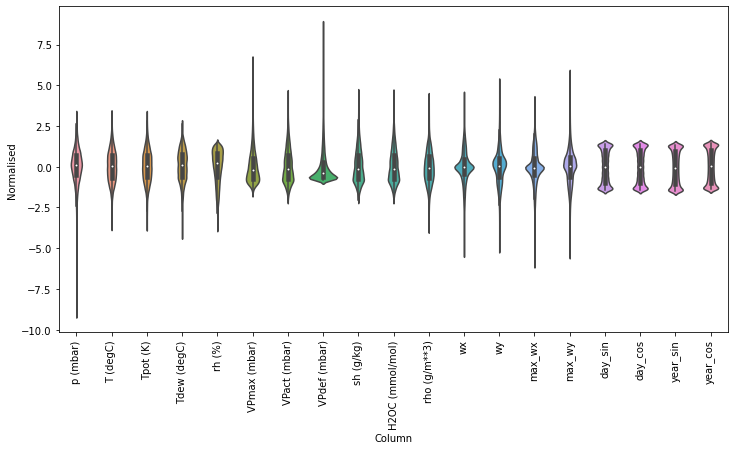

In [48]:
# Visualise the normalised data
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalised')
plt.figure(figsize=(12,6))
ax = sns.violinplot(x='Column', y='Normalised', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

We can see from the above that all the data is within a faily simialar range, -2.5 -> + 2.5. Some have long tails but thats okay as they don't seem to be huge outliers

## Data Windowing

With timeseries prediction we need to apply windowing. Due to the fact that predictions on the future points will be made given x number of past points.

The important features of each window are:
 
    LENGTH
    
    OFFSET
    
    Feature used as inputs/labels

We want to be able to perform single/multi output predictions and single/multi timestep predictions

Develop the windowing so it can be applied to all 4 types

Examples:
You want to predict the following 24 hours, given 24 hours of data you would want a 48 hour window
You want to predict one hour, given 6 hours you would use a 7 hour window etc etc

In [73]:
# Window Generator class
# Prepopulate the DF's with what we already have but can obvioiusly override later
class WindowGenerator():
    def __init__(self, input_width, label_width, shift, 
                 train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):
        # Save raw DF data
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Label Columns
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}

        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        # Window params
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    
    def __repr__(self):
        return '\n'.join([
            f'Total Window Size: {self.total_window_size}',
            f'Input Indices: {self.input_indices}',
            f'Label Indices: {self.label_indices}',
            f'Label Column Names(s): {self.label_columns}'
        ])
    
    # Given a set of features split into the specified window lengths
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)
        #slicing doesn't preserver shape info
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        
        return inputs, labels
    
    # Plot feature/lable for each window batch
    def plot(self, model=None, plot_col='T (degC)', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')
    
    # Converts a dataframe into a tf.data.Dataset
    def make_dataset(self, data):
        np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )
        
        ds = ds.map(self.split_window)
        
        return ds
    
    # Define properties that convert the train/val/test self df's to datasets
    @property
    def train(self):
        return self.make_dataset(self.train_df)
    
    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
    # Get and cache an example batch of `inputs, labels` for plotting.
        result = getattr(self, '_example', None)
        if result is None:
        # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
        # And cache it for next time
            self._example = result
        return result

In [74]:
w1 = WindowGenerator(input_width=24, label_width=1, shift=24, label_columns=['T (degC)'])
w1

Total Window Size: 48
Input Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label Indices: [47]
Label Column Names(s): ['T (degC)']

In [75]:
example = tf.stack([np.array(train_df[:w1.total_window_size]),
                    np.array(train_df[100:100+w1.total_window_size]),
                    np.array(train_df[200:200+w1.total_window_size])])

einp, elab = w1.split_window(example)
                   
print('All shapes are: (batch, time, features)')
print(f'Window shape: {example.shape}')
print(f'Inputs shape: {einp.shape}')
print(f'labels shape: {elab.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 48, 19)
Inputs shape: (3, 24, 19)
labels shape: (3, 1, 1)


Tensorflow is usually packed into arrays where the left index is the example set (batch dimension), the middle index is the time/space dimension (x) and the right index is the feature index.

We have split 3 batches of 48 hours with 19 features, into 3 * 24h 19 features feature sets and 3 * 1h * 1 label label sets.


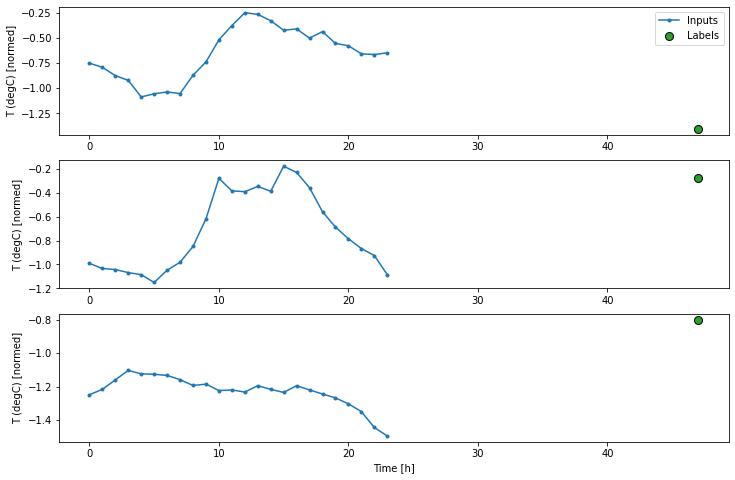

In [77]:
w1.plot()

In [79]:
# Each element is a n inputs/labels pair
w1.train.element_spec

(TensorSpec(shape=(None, 24, 19), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))

In [82]:
# Iterating over a dataset yiels batches
for einp, elab in w1.train.take(5):
    print(f'Inputs shape (batch, time, features): {einp.shape}')
    print(f'Labels shape (batch, time, features): {elab.shape}')

Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 1, 1)
Inputs shape (batch, time, features): (32, 24, 19)
Labels shape (batch, time, features): (32, 1, 1)


# Time Series Models

## Single Step Prediction (1 unit out)

#### The simplest model we can build is one that predicts a single features value, 1h into the future, given a single datapoint


In [83]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['T (degC)'])
single_step_window

Total Window Size: 2
Input Indices: [0]
Label Indices: [1]
Label Column Names(s): ['T (degC)']

Lets build a baseline model which is basically a Null Hypothesis. This model will just return the current temperature as the new temperature prediction.

This is fairly reasonable as temperature changes slowly

In [85]:
# baseline model class that extends the keras.model class
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__() # Inherit all from parent
        self.label_index = label_index
    
    def call(self, inputs): # If we have no label return the inputs
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index] # If we have the label, return the current label value as the prediction
        return result[:, :, tf.newaxis]

# instantiate and evaluate
baseline = Baseline(label_index=single_step_window.column_indices['T (degC)'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

439/439 [==============================] - 0s 975us/step - loss: 0.0128 - mean_absolute_error: 0.0785


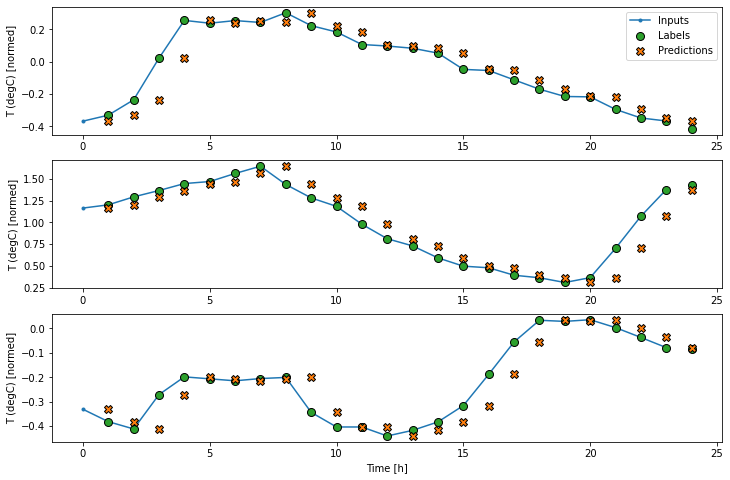

In [88]:
# Use a wider window to plot and get a feel for the actual performance
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['T (degC)'])

wide_window.plot(baseline)

The simplest type of model we can use is just a linear transformation between inp --> out.

layer.Dense() with no activation is a linear regression model. It transforms the last axis of the data from inputs -> x units of output.

In [91]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

# Create training function to simplify further
MAX_EPOCHS=20
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError()])
    
    history = model.fit(window.train, epochs=MAX_EPOCHS, validation_data=window.val, callbacks=[early_stopping])

    return history

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1534/1534 [==============================] - 2s 1ms/step - loss: 0.3444 - mean_absolute_error: 0.3387 - val_loss: 0.0319 - val_mean_absolute_error: 0.1339
Epoch 2/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0267 - mean_absolute_error: 0.1170 - val_loss: 0.0133 - val_mean_absolute_error: 0.0858
Epoch 3/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0113 - mean_absolute_error: 0.0778 - val_loss: 0.0092 - val_mean_absolute_error: 0.0702
Epoch 4/20

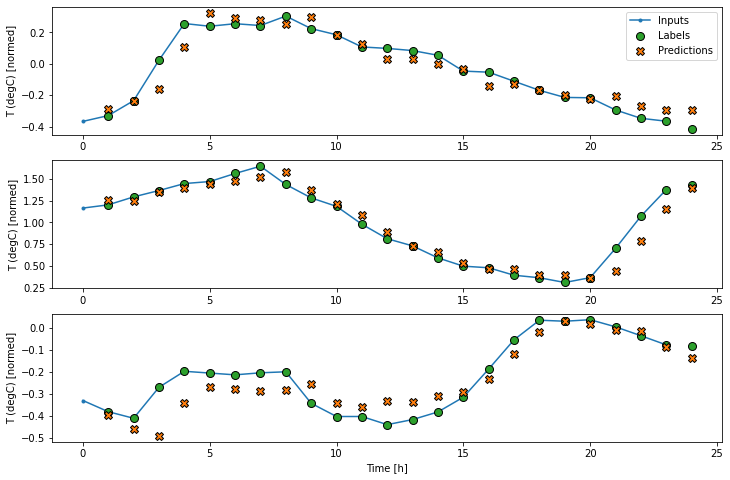

In [92]:
# Plot across a wider window
# Sometimes better, sometimes worse. How do we improve?
wide_window.plot(linear)

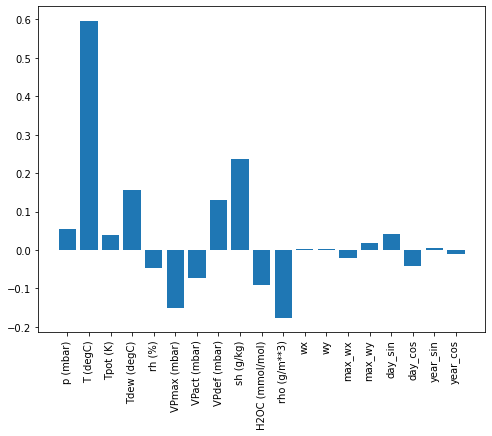

In [93]:
# An advantage of linear models is they are easy to interpret, you can extract the weights at each layer
# and see exactly how much of as contribution each feature has at each point
# Sometimes the model wont even place the most weight on the current temperature, due to the random weight init
plt.bar(x=range(len(train_df.columns)), height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

## Dense (Almost Linear) Model
Look at a deeper Nueral Net approach using a single timestep. Can it gain more info from the 19 features?

In [94]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1534/1534 [==============================] - 3s 2ms/step - loss: 0.0134 - mean_absolute_error: 0.0785 - val_loss: 0.0075 - val_mean_absolute_error: 0.0626
Epoch 2/20
1534/1534 [==============================] - 2s 2ms/step - loss: 0.0080 - mean_absolute_error: 0.0650 - val_loss: 0.0073 - val_mean_absolute_error: 0.0619
Epoch 3/20
1534/1534 [==============================] - 3s 2ms/step - loss: 0.0075 - mean_absolute_error: 0.0623 - val_loss: 0.0068 - val_mean_absolute_error: 0.0578
Epoch 4/20

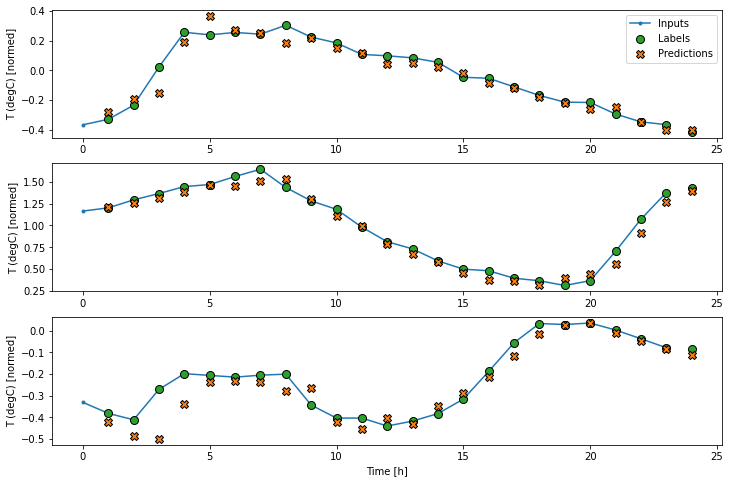

In [95]:
wide_window.plot(dense)
# Looks pretty similar to the linear model tbf. Can't really predict much seen as it has nor historical knowledge

### Multi-Step Dense

Use multiple input steps, to predict 1 output step

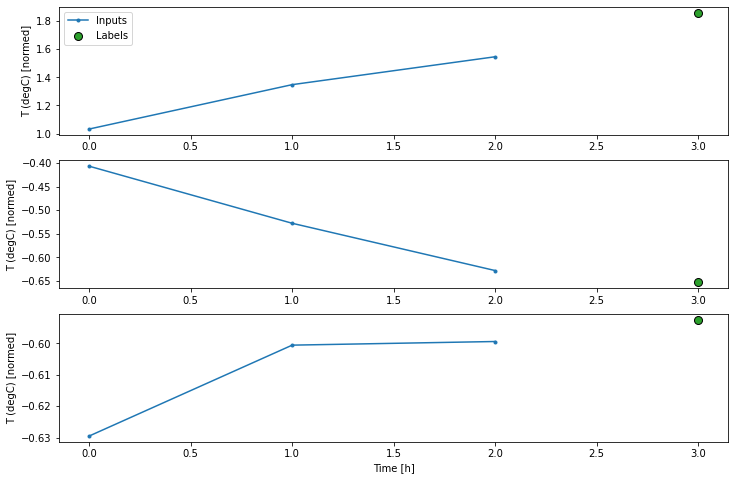

In [96]:
CONV_WIDTH=3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['T (degC)']
)

conv_window.plot()

In [97]:
# try a multistep dense model?
multi_step_dense = tf.keras.Sequential([
    # Flatten is a very useful step. It collapses the multidimensional input into s single layer
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Now we need to undo the flatten by adding the time dimension back
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1])
])

history = compile_and_fit(multi_step_dense, conv_window)
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

Epoch 1/20

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

1534/1534 [==============================] - 2s 1ms/step - loss: 0.0338 - mean_absolute_error: 0.1037 - val_loss: 0.0083 - val_mean_absolute_error: 0.0666
Epoch 2/20
1534/1534 [==============================] - 2s 1ms/step - loss: 0.0083 - mean_absolute_error: 0.0664 - val_loss: 0.0071 - val_mean_absolute_error: 0.0605
Epoch 3/20
1534/1534 [==============================] - 2s 2ms/step - loss: 0.0075 - mean_absolute_error: 0.0621 - val_loss: 0.0068 - val_mean_absolute_error: 0.0587
Epoch 4/20

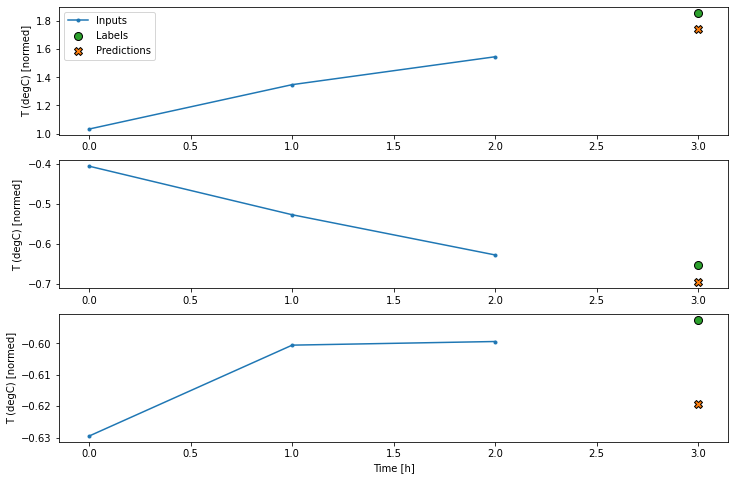

In [99]:
conv_window.plot(multi_step_dense)
# This model is okay but its limited to the exact input shape specified.

## CNN

Convolutional Neural Nets are able to fix the limiting input shape problem

A convolutional layer (layers.Conv1D) also takes multiple steps (time or otherwise) as input to each prediction, but it does a tensor covolution to a single dimension (time or otherwise). It thus preservers the index shape of the input so we dont need to flatten or reshape

In [101]:
conv_model =  tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=(CONV_WIDTH,), activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()

val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

438/438 [==============================] - 0s 1ms/step - loss: 0.0062 - mean_absolute_error: 0.0545


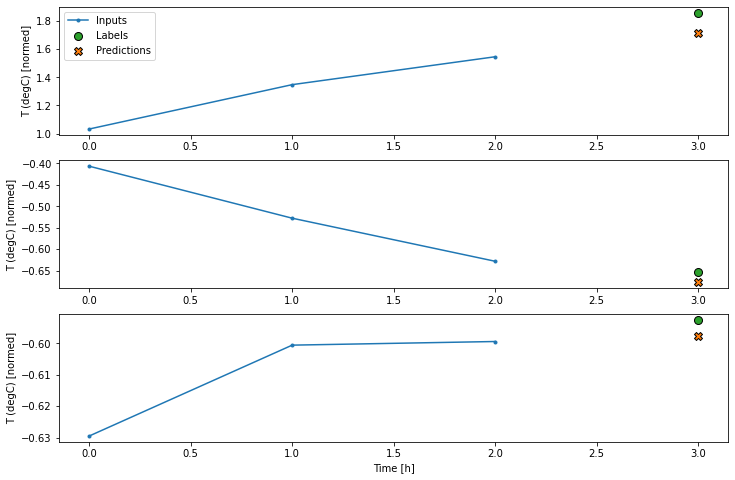

In [102]:
# We get a similar performance to the multistep dense, little bit better but not hugely
# The difference here is that the conv model can be run on inputs on any size, the convolutional layer
# is applied to a sliding window of inputs by design
conv_window.plot(conv_model)

In [103]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

# We can see that a wider input gives a wider output as expected, but the output is a bit shorter than the input
# By the window_size-1.
# Make a window generator thats a bit longer so we can plot it

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [105]:
LABEL_WIDTH=24
INPUT_WIDTH=LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['T (degC)']
)

wide_conv_window

Total Window Size: 27
Input Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label Indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label Column Names(s): ['T (degC)']

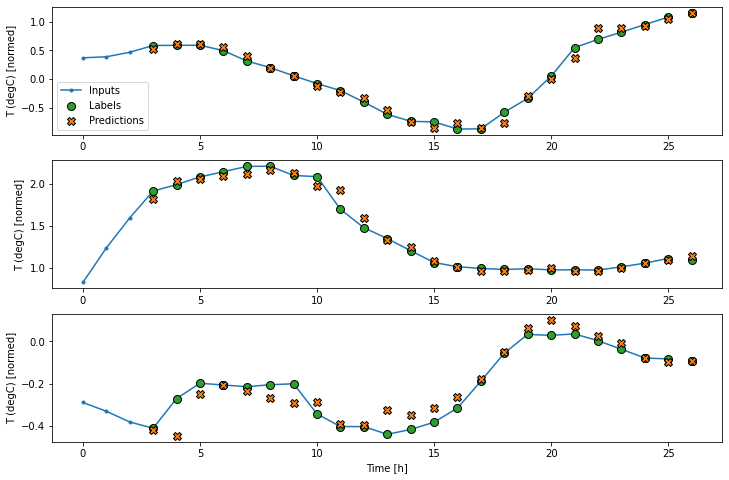

In [106]:
# This aint too bad?
wide_conv_window.plot(conv_model)

## Recurrent Neural Network

RNN are inherently good for TimeSeries. They process each time step by step and store an internal state with knowledge of this stepping as it goes.

Here we will use LONG SHORT TERM MEMORY, is a type of time series focussed NN architechture that remembers values for an arbitrary time and is able to selectively remember/forget information to aid in training.

IMPORTANT FEATURE:
For keras RNN you must specify the return_sequences=True/False

False = only return output of final timestep, basically giving the model a 'warmup' time before prediction

True = returns a prediction for every timestep. This is good for stacking RNN layers & training on multiple steps at once.

In [119]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

# with return sequences=True we can train on all 24 data points at once, However, we can only access all 24 at the end of the window...

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 1s 2ms/step - loss: 0.0057 - mean_absolute_error: 0.0525


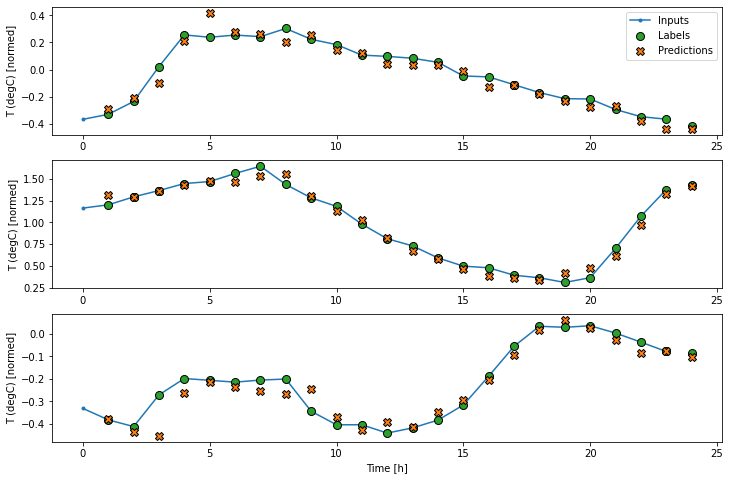

In [120]:
wide_window.plot(lstm_model)

Wide window
Input shape: (32, 24, 19)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


437/437 [==============================] - 1s 2ms/step - loss: 0.1589 - mean_absolute_error: 0.3060


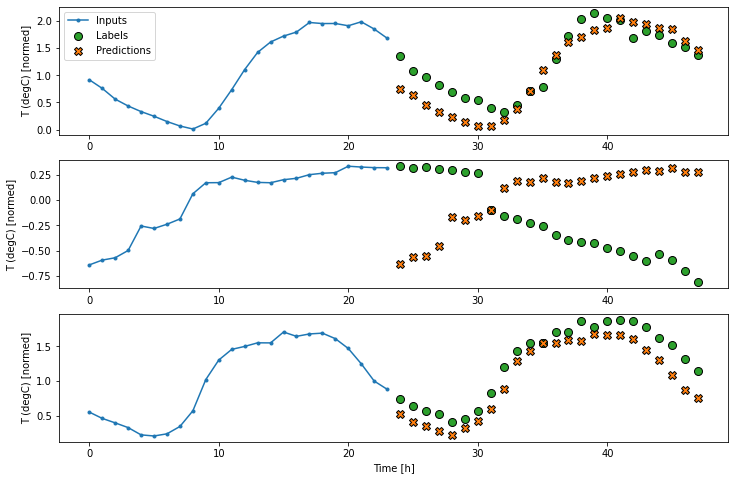

In [118]:
lstm_wide_window.plot(lstm_model)

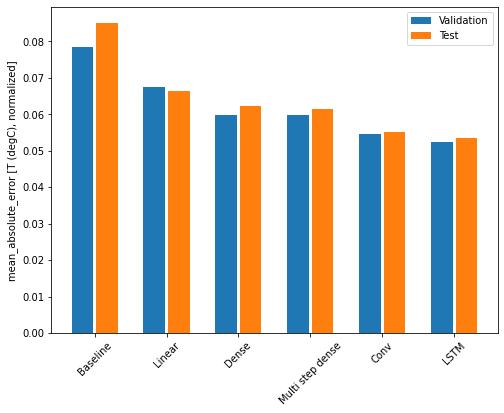

In [121]:
# On this DS all the models do progressively better than each other
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [122]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.0852
Linear      : 0.0664
Dense       : 0.0623
Multi step dense: 0.0615
Conv        : 0.0551
LSTM        : 0.0536


### Multi Output Models

All the previous models can be converted to multi output, by increasing the number of units in the final layer.

If we make a window which has all the features as labels, and pass that as an input to the models then we can predict all the outputs

In [124]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1)
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1)

In [125]:
# Baseline
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test, verbose=0)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

438/438 [==============================] - 0s 1ms/step - loss: 0.0886 - mean_absolute_error: 0.1589


In [126]:
# Dense
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

439/439 [==============================] - 1s 1ms/step - loss: 0.0685 - mean_absolute_error: 0.1328


In [127]:
# RNN
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

438/438 [==============================] - 1s 3ms/step - loss: 0.0623 - mean_absolute_error: 0.1224


Residual Connections. In time series prediction the next value usually doesn't change much so its not always the most accurrate to predict the next value, sometimes it better to predict the amount of change. 

The models had to learn that the changes were small, so it can be better to encode this knowledge either by parameter tuning or residual connections.

Residual Nets take advantage of the fact the change should be small by basically initialising as a BASELINE Model whiere there is no change.

We can write a wrapper that initialises with predictions that change should be 0 in the first layer.

In [131]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each timestep is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.Dense(
            num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
            kernel_initializer=tf.initializers.zeros)
    ]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)

438/438 [==============================] - 1s 2ms/step - loss: 0.0621 - mean_absolute_error: 0.1181


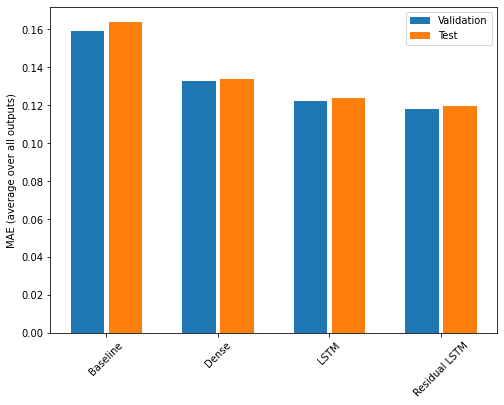

In [132]:
# Performance of MO models
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

Thus far the best models have been the single output ones.

# Multi Step Models

These aim to predict a series of outputs.

There are two rough approaches to this:

1) Single shot, predict whole time series at once

2) Autoregressive, single step model, which uses its output as an input to the next step

Total Window Size: 48
Input Indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label Indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label Column Names(s): None

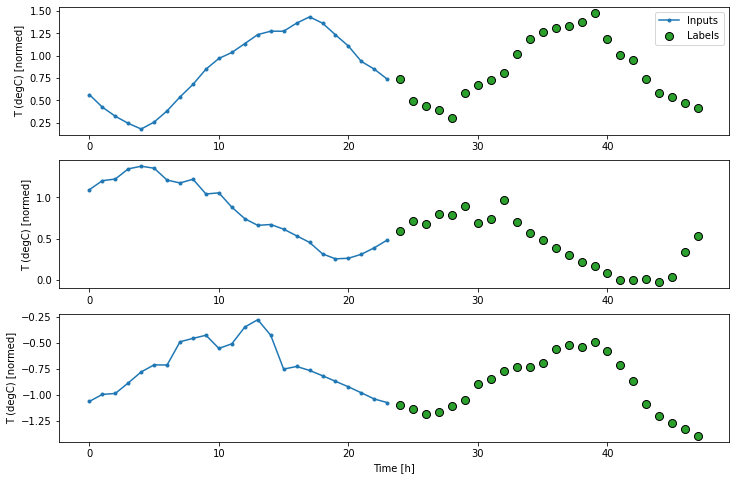

In [163]:
# Window
OUT_STEPS = 24
multi_window = WindowGenerator(
    input_width=24,
    label_width=OUT_STEPS,
    shift=OUT_STEPS
)

multi_window.plot()
multi_window


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

437/437 [==============================] - 0s 1ms/step - loss: 0.6285 - mean_absolute_error: 0.5007


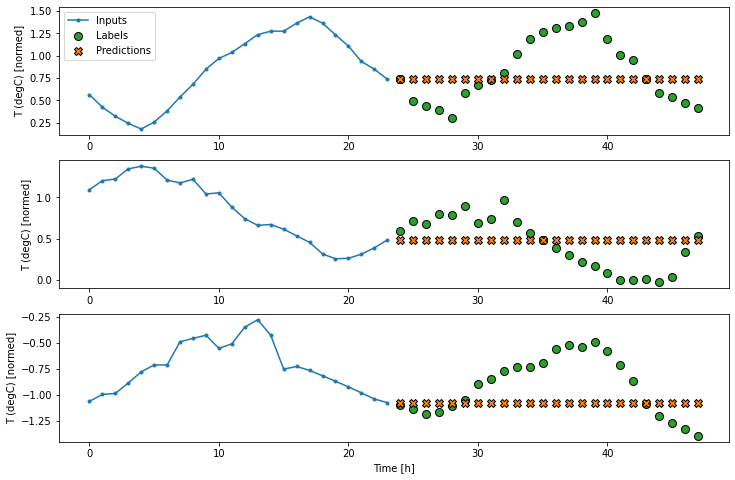

In [170]:
# Simple baseline is to just predict the last value for all forward values
class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
        return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])
    
last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

437/437 [==============================] - 0s 1ms/step - loss: 0.4271 - mean_absolute_error: 0.3960


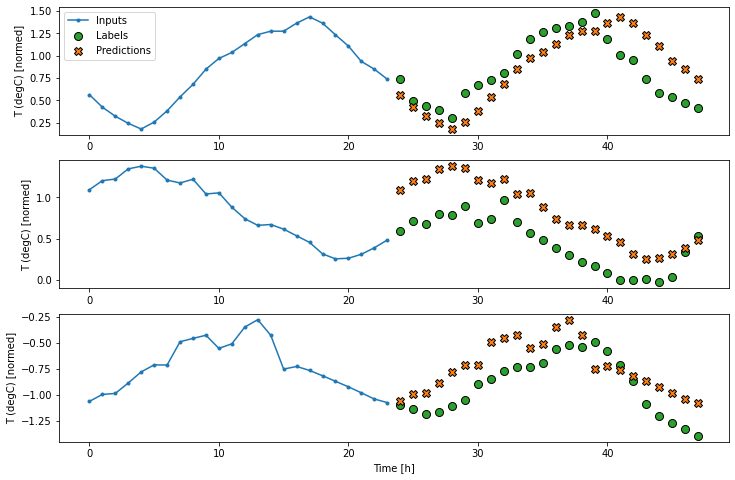

In [171]:
# Another simple baseline would be to just repeat the input baseline
class RepeatBaseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__() # Inherit all from parent
        self.label_index = label_index

    def call(self, inputs):
        return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

## SIngle Shot Models

We can implent this efficently by using layers.Dense(OUT_STEPS*features) as output units

We just need to reshape to (output_steps, features)

A simple linear model does better than the baselines but it lacks depth and is most likely just predicting oscillation from the time of day/year, because its only reference is a single value point inpt

437/437 [==============================] - 0s 1ms/step - loss: 0.2555 - mean_absolute_error: 0.3056


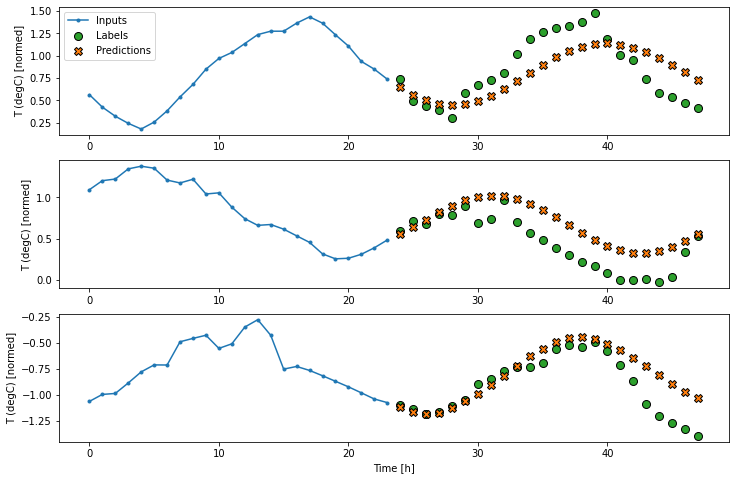

In [172]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

437/437 [==============================] - 1s 2ms/step - loss: 0.2218 - mean_absolute_error: 0.2858


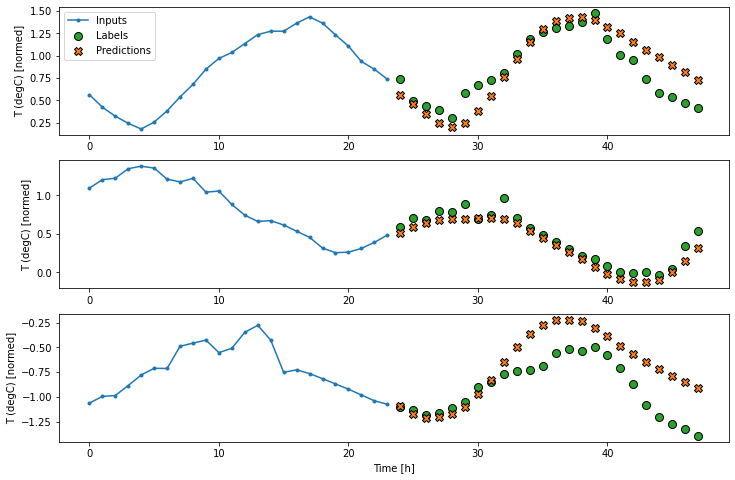

In [173]:
# Adding a dense layer makes it a bit better but it still only based on a single final timestep
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

437/437 [==============================] - 1s 1ms/step - loss: 0.2144 - mean_absolute_error: 0.2801


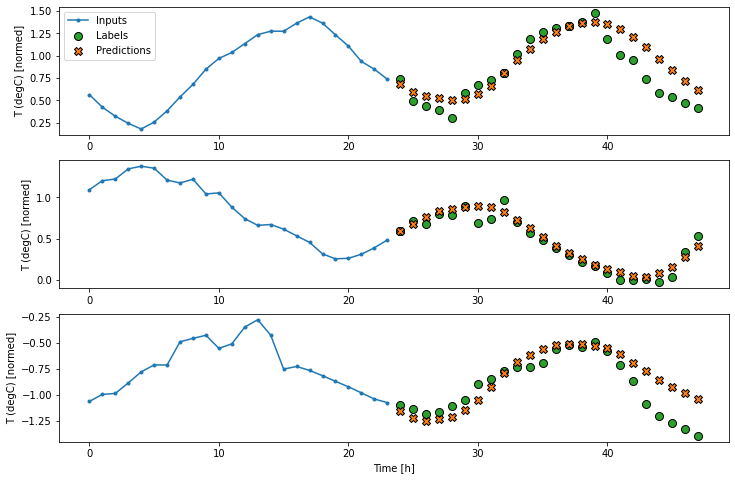

In [174]:
# The convolutional model will predict using a fixed width history which might be better for single shot
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

437/437 [==============================] - 1s 3ms/step - loss: 0.2136 - mean_absolute_error: 0.2844


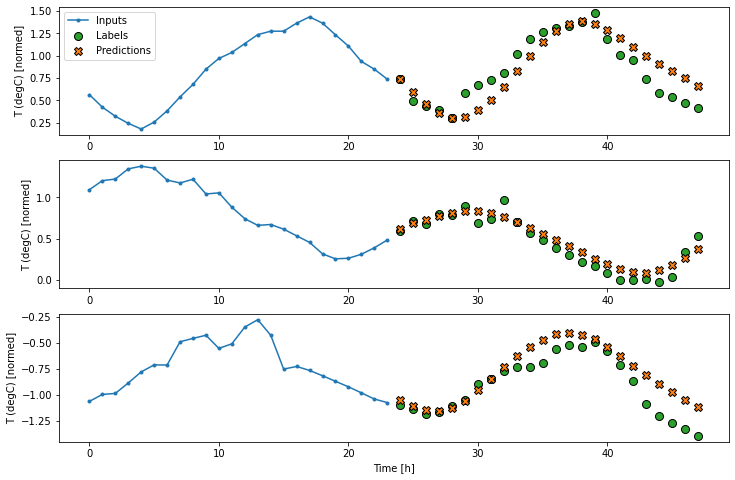

In [175]:
# Recurrent models can train on long histories of inputs if its relevant to the model
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

## AutoRegressive model

An autoregressive model uses the previous single output as an input to the next prediction.

We could write a feedback wrapper and put it around any of the single output models developed earlier.

In [178]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        self.dense = tf.keras.layers.Dense(num_features)
    
    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []
        # Initialize the lstm state
        prediction, state = self.warmup(inputs)

        # Insert the first prediction
        predictions.append(prediction)

        # Run the rest of the prediction steps
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])

        return predictions

feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Output shape (batch, time, features):  (32, 24, 19)


437/437 [==============================] - 1s 3ms/step - loss: 0.2233 - mean_absolute_error: 0.2973


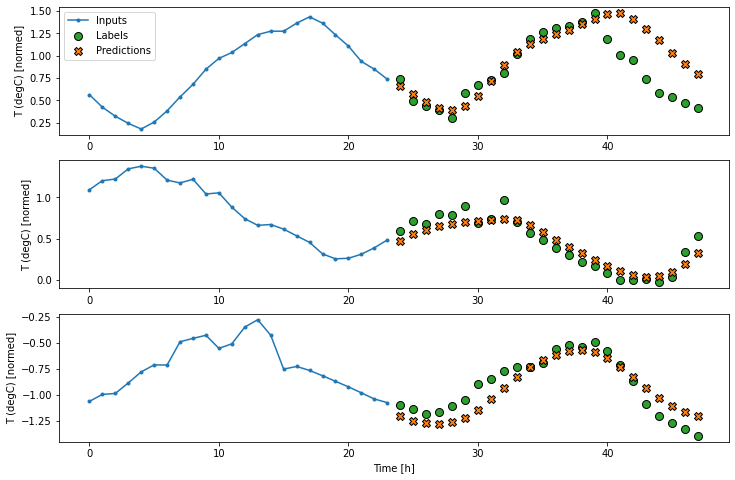

In [179]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

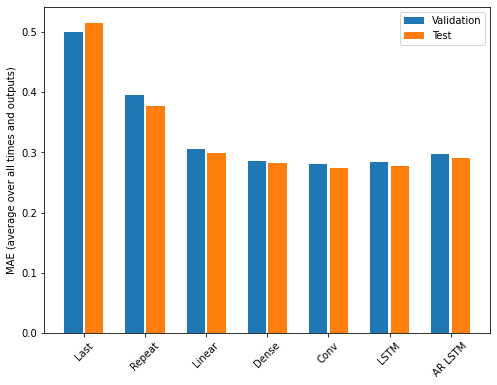

In [180]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

The multistep predictions and the autoregressive mdoels all do worse than the single step models. CLearl ythe model complexity compounds errors in this dataset